### Reference

<a href='https://pytorch.org/docs/stable/nn.html'>PyTorch NN</a>

<a href='https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html'>Fine Tuning Tutorial</a>

<a href='https://pytorch.org/docs/stable/data.htm'>Data</a>

<a href='https://pytorch.org/tutorials/beginner/basics/data_tutorial.html'>DataLoaders Tutorial</a>

<a href='https://pytorch.org/vision/stable/generated/torchvision.utils.draw_bounding_boxes.html'>Draw bounding boxes</a>

<a href='https://pytorch.org/vision/stable/auto_examples/plot_transforms_v2.html'>Transform v2 Function</a>

# CV PIPELINE EXAMPLE

1. Собрать датасет
2. Загрузка датасета (даталоадеры)
3. Предоработка данных -- /255, .float(), resize, centercrop, augmentations, normalize, to_tensor
4. Сетап модели
5. Задание гиперпараметров (оптимизитор, лосс, числовые параметры)
6. Цикл обучения
- Основная цель -- обновление весов
- Что-то на каждой итерации (логирование текущих метрик, сохранение весов. политика изменения гиперпараметров)
7. Метрики качества на обучении, валидации и тесте
8. Логирования результатов для воспроизводимости
Прод:
9. Убедиться, что модель подгружается
10. Сохранение в более компактном формате (конвертация/изменение весов, ускорение, jit-компиляции)
11. Запуск на целевом устройстве




### IMPORT LIBRARIES

In [1]:
!pip install -q split-folders

In [2]:
import os
import time
from tqdm.notebook import tqdm

# download data
import cv2
from PIL import Image
from pathlib import Path
import splitfolders

# from efficientnet_pytorch import EfficientNet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms, datapoints
from torchvision.datasets import ImageFolder
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.v2 import functional as FT
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [4]:
from tensorflow import keras

In [5]:
# Проверим доступность GPU на CUDA
torch.cuda.is_available()
use_gpu = torch.cuda.is_available()
use_gpu

True

In [6]:
# Добавим cuda на девайс
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

### IMPORT DATA

In [7]:
# celeba images 0-30k archive
!gdown 1MIA99QUIxXvaBFOZFbVsVoYJPL-6_FzN -O /content/celeba/

Downloading...
From: https://drive.google.com/uc?id=1MIA99QUIxXvaBFOZFbVsVoYJPL-6_FzN
To: /content/celeba/0-30k.zip
100% 1.56G/1.56G [00:15<00:00, 97.7MB/s]


In [8]:
# identity person
!gdown 1ZEKVXe54rFwI2vPgCKDGE-d0BJWZ2NDp -O /content/celeba/

Downloading...
From: https://drive.google.com/uc?id=1ZEKVXe54rFwI2vPgCKDGE-d0BJWZ2NDp
To: /content/celeba/identity_CelebA.txt
100% 3.42M/3.42M [00:00<00:00, 249MB/s]


In [9]:
# image attributes
!gdown 1Upj8NyGp7nGoslEuQHirfjYFHA37PJCa -O /content/celeba/

Downloading...
From: https://drive.google.com/uc?id=1Upj8NyGp7nGoslEuQHirfjYFHA37PJCa
To: /content/celeba/list_attr_celeba.txt
100% 26.7M/26.7M [00:00<00:00, 140MB/s] 


In [10]:
# image bbox
!gdown 1Tvpz-ZHeYpwhe16_QJwUCjY416d9z-ar -O /content/celeba/

Downloading...
From: https://drive.google.com/uc?id=1Tvpz-ZHeYpwhe16_QJwUCjY416d9z-ar
To: /content/celeba/list_bbox_celeba.txt
100% 6.08M/6.08M [00:00<00:00, 191MB/s]


In [11]:
mkdir -p /content/celeba/images/0_30k/

In [12]:
!unzip /content/celeba/0-30k.zip  -d /content/celeba/images/0_30k/ &>/dev/null

In [13]:
# !unzip img_align_celeba.zip &>/dev/null

In [14]:
# os.rename('/content/celeba/images', '/content/celeba/images_0_30k')

In [15]:
ROOT = "/content/celeba/images/0_30k/"
ALL_IMAGES = list(Path(ROOT).glob("**/*.jpg"))
ALL_IMAGES = list(filter(lambda x: not x.name.startswith("."), ALL_IMAGES))
print("Number of images:", len(ALL_IMAGES))

Number of images: 30000


### CHECK IMAGES

**WAY ONE**

In [16]:
PATH = Path('/content/celeba/images/')

In [17]:
images = [p.resolve() for p in PATH.glob("**/*") if p.suffix in {".png", ".jpg", ".jpeg"}]

In [18]:
images[:3]

[PosixPath('/content/celeba/images/0_30k/004309.jpg'),
 PosixPath('/content/celeba/images/0_30k/005305.jpg'),
 PosixPath('/content/celeba/images/0_30k/006419.jpg')]

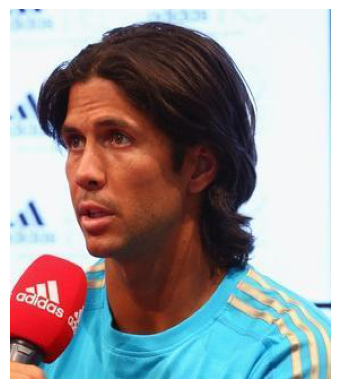

In [19]:
img = Image.open(images[2]) # RGB!
plt.imshow(img)
plt.axis("off");

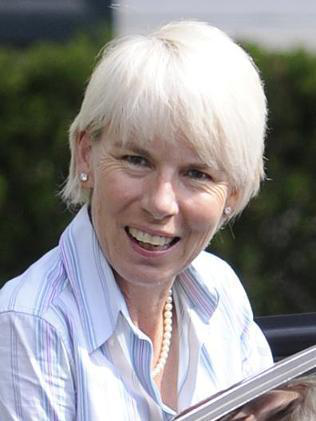

In [20]:
img = Image.open('/content/celeba/images/0_30k/003406.jpg')
img

In [21]:
np.asarray(img).shape

(421, 316, 3)

**WAY TWO**

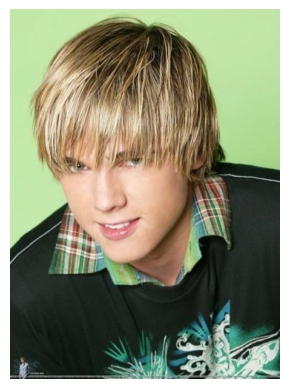

In [22]:
img = cv2.imread(str(images[0])) # BGR!
plt.imshow(img[...,::-1]) # BGR -> RGB
plt.axis("off")
plt.show()

In [23]:
img.shape

(500, 364, 3)

**WAY THREE**

In [24]:
ALL_IMAGES = list(Path(PATH).glob("**/*.jpg"))
ALL_IMAGES = list(filter(lambda x: not x.name.startswith("."), ALL_IMAGES))
print("Number of images:", len(ALL_IMAGES))

Number of images: 30000


**WAY FOUR**

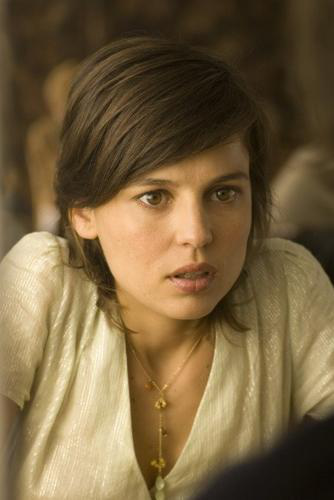

In [25]:
img = keras.utils.load_img('/content/celeba/images/0_30k/020120.jpg')
img

In [26]:
keras.utils.img_to_array(img).shape

(500, 334, 3)

In [27]:
print(keras.utils.img_to_array(img).min())
print(keras.utils.img_to_array(img).max())

0.0
255.0


### SPLIT DATA

**WAY ONE**

In [19]:
INPUT_PATH = '/content/celeba/images/'
SPLIT_PATH = '/content/celeba/split'

splitfolders.ratio(
                    INPUT_PATH,
                    SPLIT_PATH,
                    seed=42,
                    ratio=(.8, .1, .1),
                    group_prefix=None,
                    move=False
)

Copying files: 30000 files [00:07, 4239.31 files/s]


In [20]:
TRAIN_PATH = SPLIT_PATH / Path("train")
images = [p.resolve() for p in TRAIN_PATH.glob("**/*") if p.suffix in {".png", ".jpg", ".jpeg"}]
len(images)

24000

**WAY TWO**

TensorFlow

In [30]:
batch_size = 16

train_ds = keras.utils.image_dataset_from_directory(
  INPUT_PATH,
  validation_split=0.2,
  subset="training",
  seed=42,
  batch_size=batch_size)

Found 30000 files belonging to 1 classes.
Using 24000 files for training.


In [31]:
val_ds = keras.utils.image_dataset_from_directory(
  INPUT_PATH,
  validation_split=0.2,
  subset="validation",
  seed=42,
  batch_size=batch_size)

Found 30000 files belonging to 1 classes.
Using 6000 files for validation.


### DATA TRANSFORM

1. Сделай до загрузки датасета, чтобы  можно было итерироваться по даталоадеру
2. Если используешь предобученную модель смотри, какая нормализация была у исходного датасета. Иначе веса не будут работать т.к. модель не видела таких значений.
3. Ресайз обязателен для моделей с FC слоями или моделей без пуллингов, которые приводят feature map к одному размеру
4. Ресайз может быть с интерполяцией или кропом, обращай на это внимание, чтобы не обрезать/искозить важную информацию

**ToTensor**

Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8


**Зачем нормализация**
- разделяющую гиперплоскость будет точнее отделять классы
-  обеспечения стабильности обучения модели и повышения ее устойчивости к различным условиям освещения и цветовым характеристикам изображений (робастность, выбросы)
- для предобученных моделей

In [21]:
transform_train = transforms.Compose(
                [
                 transforms.Resize((224, 224)),
                 # transforms.RandomHorizontalFlip(p=.5),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                 ]
)


transform_val = transforms.Compose(
                [
                 transforms.Resize((224, 224)),
                 # transforms.RandomHorizontalFlip(p=.5),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                 ]
)

### DATALOADERS

In [22]:
train_ds = ImageFolder(TRAIN_PATH)

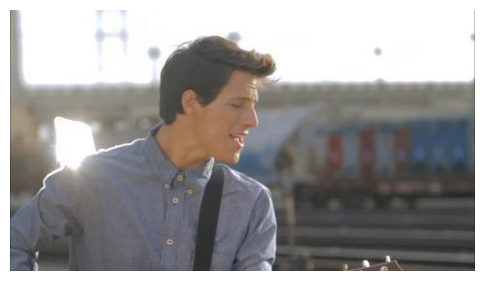

In [71]:
plt.figure(figsize=(6, 6))
plt.axis("off")
plt.imshow(train_ds[2][0]);

In [72]:
np.asarray(train_ds[2][0])[0, :3]

array([[122, 119, 114],
       [159, 156, 149],
       [155, 155, 145]], dtype=uint8)

In [94]:
train_ds = ImageFolder(TRAIN_PATH, transform_train)

In [80]:
train_ds[0][0].shape

torch.Size([3, 224, 224])

In [81]:
train_ds[0][0].numpy().transpose(1, 2, 0).shape

(224, 224, 3)

In [82]:
train_ds[0][0].permute(1, 2, 0).shape

torch.Size([224, 224, 3])

In [83]:
train_ds[0][0].unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

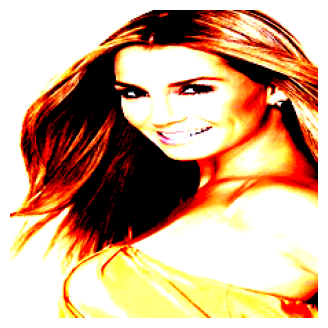

In [84]:
plt.figure(figsize=(4, 4))
plt.axis("off")
plt.imshow(train_ds[0][0].permute(1, 2, 0));

In [85]:
np.asarray(train_ds[0][0])[:1][:1]

array([[[2.2146587, 2.2146587, 2.2146587, ..., 2.2317834, 2.2317834,
         2.2317834],
        [2.2146587, 2.2146587, 2.2146587, ..., 2.2317834, 2.2317834,
         2.2317834],
        [2.2146587, 2.2146587, 2.2146587, ..., 2.2317834, 2.2146587,
         2.2146587],
        ...,
        [2.1975338, 2.2146587, 2.2317834, ..., 2.1461596, 2.0262864,
         2.11191  ],
        [2.2146587, 2.2146587, 2.2146587, ..., 2.1975338, 2.0262864,
         2.0434113],
        [2.2146587, 2.2146587, 2.2146587, ..., 2.2146587, 2.129035 ,
         1.9749122]]], dtype=float32)

In [86]:
print(np.asarray(train_ds[0][0]).min())
print(np.asarray(train_ds[0][0]).max())

-2.117904
2.5877128


**DATALOADER**

The optimal number of workers: https://chtalhaanwar.medium.com/pytorch-num-workers-a-tip-for-speedy-training-ed127d825db7

In [23]:
batch_size=16
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

In [24]:
# https://stackoverflow.com/questions/62549990/what-does-next-and-iter-do-in-pytorchs-dataloader
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1, 2, 0)

# back transformation
img = img.numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)

label = train_labels[0]
plt.axis("off")
plt.title(label)
plt.imshow(img)
plt.show()

TypeError: ignored

In [ ]:
VAL_PATH = SPLIT_PATH / Path("val")
TEST_PATH = SPLIT_PATH / Path("test")

val_ds = ImageFolder(VAL_PATH, transform_val)
test_ds = ImageFolder(TEST_PATH, transform_val)

val_dataloader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2)

### IMPORT MODELS

In [90]:
# !pip install -U ultralytics &>/dev/null
# model = torch.hub.load('ultralytics/yolov5', 'yolov5l6', pretrained=True)
# model = model.cuda()

In [55]:
batch_size=16

transform_train = transforms.Compose(
                [
                 transforms.Resize((500, 350)),
                 # transforms.RandomHorizontalFlip(p=.5),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                 ]
)


transform_val = transforms.Compose(
                [
                 transforms.Resize((500, 350)),
                 # transforms.RandomHorizontalFlip(p=.5),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                 ]
)


TRAIN_PATH = SPLIT_PATH / Path("train")
VAL_PATH = SPLIT_PATH / Path("val")
TEST_PATH = SPLIT_PATH / Path("test")

train_ds = ImageFolder(TRAIN_PATH, transform_train)
val_ds = ImageFolder(VAL_PATH, transform_val)
test_ds = ImageFolder(TEST_PATH, transform_val)

train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

In [25]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1').to(DEVICE)
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='COCO_V1').to(DEVICE)
# model = torchvision.models.detection.retinanet_resnet50_fpn(weights='COCO_V1').to(DEVICE)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 56.1MB/s]


### BASIC PREDICTION

In [98]:
# https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
images, _ = next(iter(train_dataloader))
images = images.to(DEVICE)
# переводим модель в режим предсказания
model.eval()
# выключаем расчет градиентов
with torch.no_grad():
    predictions = model(images)

In [99]:
predictions[2]

{'boxes': tensor([[  0.0000,  66.2427, 349.4680, 500.0000],
         [  4.4208,  98.9949, 183.1269, 500.0000],
         [ 10.3276, 280.5589, 319.2192, 500.0000],
         [158.2959, 125.2080, 350.0000, 500.0000],
         [ 68.6516, 219.2223, 149.8253, 338.9762],
         [  7.3074,  18.5078, 304.8311, 283.6769],
         [ 67.6869, 212.1493, 152.8616, 348.3432],
         [111.4596,   0.0000, 350.0000, 240.9798],
         [  0.0000, 320.7783, 145.4279, 498.5796],
         [116.3758,   4.7052, 350.0000, 231.3020],
         [ 70.4078, 222.7483, 149.8781, 347.0056],
         [121.6216,   0.0000, 348.9875, 237.8046],
         [103.8491, 209.8821, 350.0000, 479.7923],
         [118.9348,   5.5345, 350.0000, 234.7889]], device='cuda:0'),
 'labels': tensor([ 1,  1,  1,  1, 70,  1, 11,  3,  3, 81, 86, 17,  3, 51],
        device='cuda:0'),
 'scores': tensor([0.6704, 0.2269, 0.1532, 0.1530, 0.1288, 0.1074, 0.1035, 0.0987, 0.0967,
         0.0653, 0.0578, 0.0570, 0.0570, 0.0509], device='cuda:0'

(500, 350, 3)


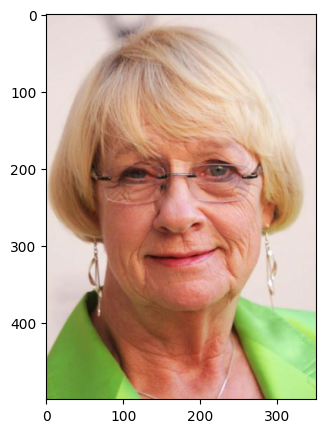

In [100]:
img = images[2].permute(1, 2, 0)
img = img.cpu().numpy()

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
print(img.shape)
fig = plt.figure(figsize=(5,5))
plt.imshow(img);

In [26]:
label_names = FasterRCNN_ResNet50_FPN_Weights.COCO_V1.meta["categories"]
label_names[:3]

['__background__', 'person', 'bicycle']

In [27]:
def inv_transforms(img):
  inv_transforms = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
  return inv_transforms(img)

In [28]:
def get_label_names(labels, label_names):
  labels = labels.cpu().tolist()
  return [label_names[x] for x in labels]

In [29]:
def show_preds(image, prediction=None, threshold=None):
  if prediction is not None and threshold is not None:
    img = inv_transforms(image)
    img = FT.convert_dtype(img, torch.uint8)
    boxes = prediction['boxes'][prediction['scores'] > CONF_THRESH]
    label = prediction['labels'][prediction['scores'] > CONF_THRESH]
  elif prediction is not None and threshold is None:
    img = inv_transforms(image)
    img = FT.convert_dtype(img, torch.uint8)
    boxes = prediction
    label = torch.tensor([1])
  else:
    img = inv_transforms(image[0])
    img = FT.convert_dtype(img, torch.uint8)
    boxes = image[1]['boxes']
    label = image[1]['labels']
  label = get_label_names(label, label_names)
  annotated_image = draw_bounding_boxes(img, boxes, labels=label, colors="red", width=1)
  fig, ax = plt.subplots()
  ax.imshow(annotated_image.permute(1, 2, 0).cpu().numpy())
  ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
  fig.tight_layout()
  fig.show()

/usr/local/lib/python3.10/dist-packages/torchvision/utils.py:210: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


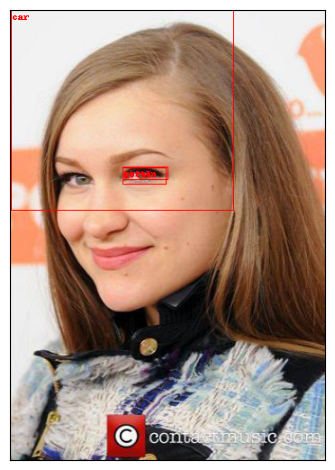

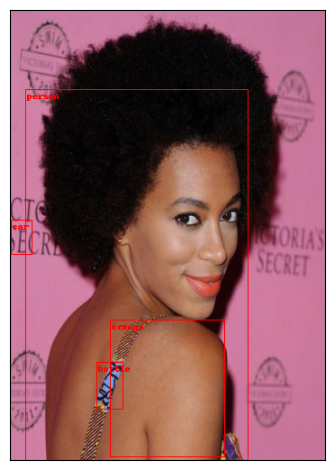

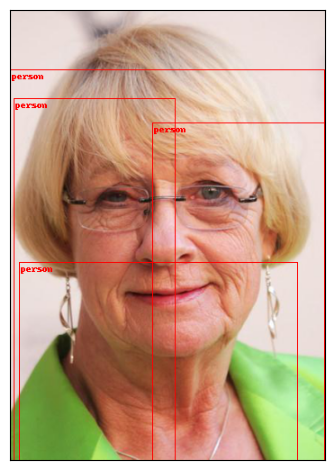

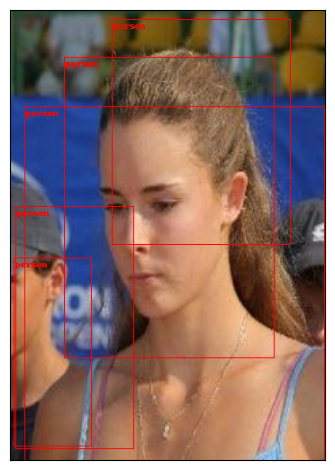

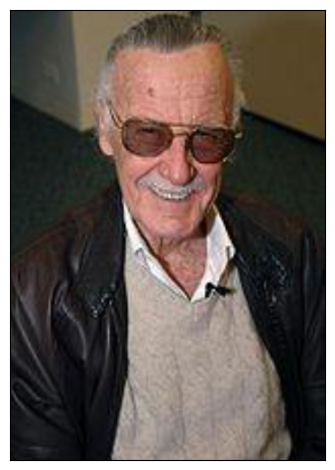

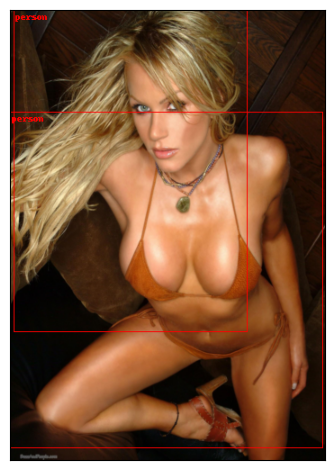

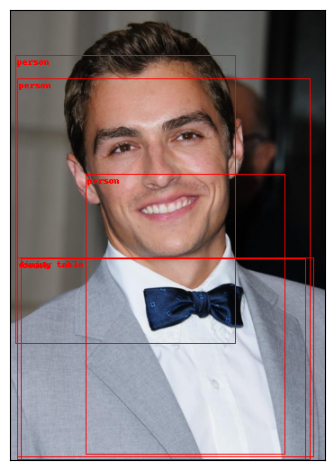

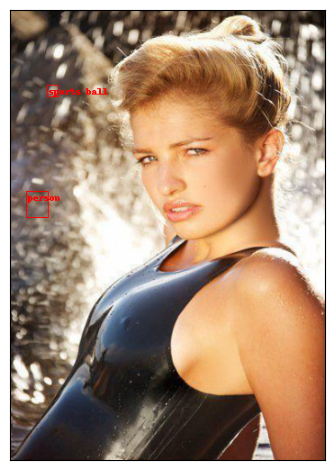

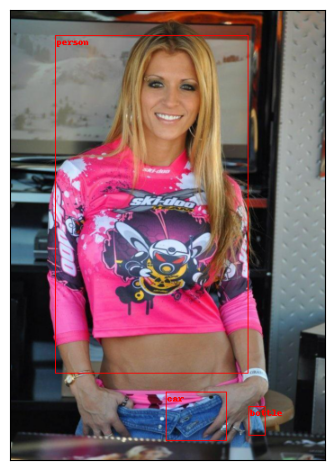

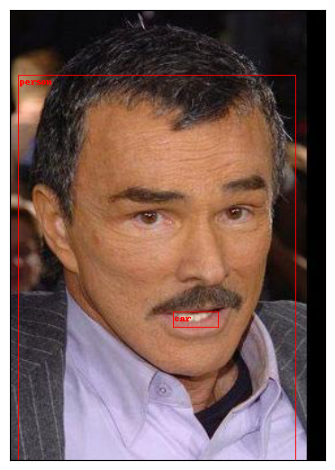

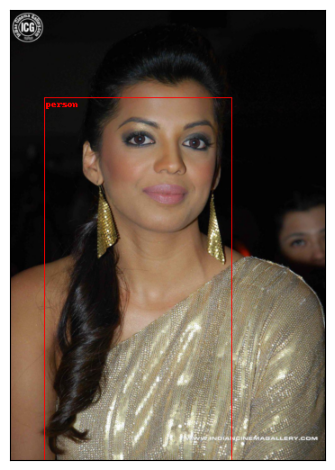

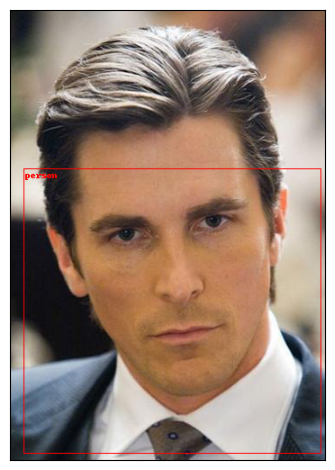

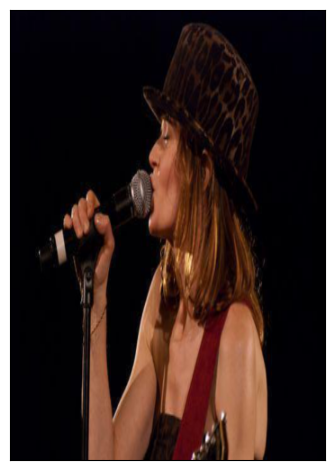

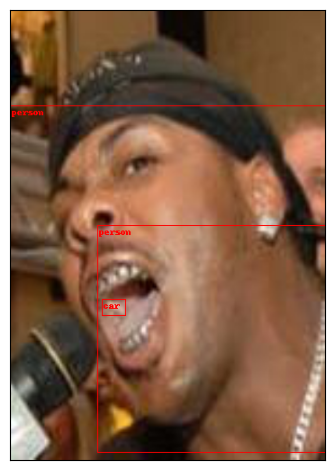

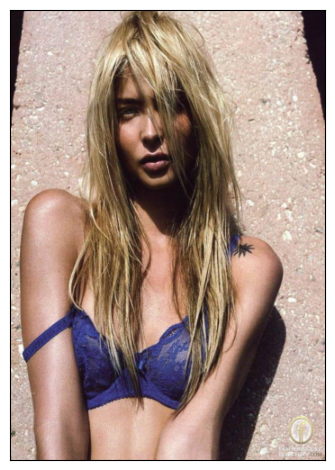

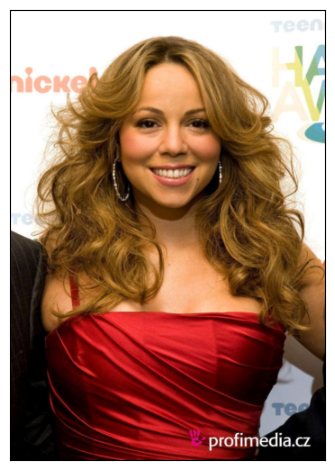

In [105]:
CONF_THRESH = 0.15

for i in range(batch_size):
  show_preds(images[i], predictions[i], CONF_THRESH)

# DATA PREPARATION

In [30]:
identity_celeba = pd.read_csv('/content/celeba/identity_CelebA.txt', delim_whitespace=True, names=['image', 'id'])
identity_celeba.head()

image    id
0  000001.jpg  2880
1  000002.jpg  2937
2  000003.jpg  8692
3  000004.jpg  5805
4  000005.jpg  9295

In [31]:
attr_celeba = pd.read_csv('/content/celeba/list_attr_celeba.txt', delim_whitespace=True, header=1)
attr_celeba.head()

5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
000001.jpg                -1                1           1               -1   
000002.jpg                -1               -1          -1                1   
000003.jpg                -1               -1          -1               -1   
000004.jpg                -1               -1           1               -1   
000005.jpg                -1                1           1               -1   

            Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  ...  \
000001.jpg    -1     -1        -1        -1          -1          -1  ...   
000002.jpg    -1     -1        -1         1          -1          -1  ...   
000003.jpg    -1     -1         1        -1          -1          -1  ...   
000004.jpg    -1     -1        -1        -1          -1          -1  ...   
000005.jpg    -1     -1         1        -1          -1          -1  ...   

            Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
000001.jpg         -1        1              1         -1                 1   
000002.jpg         -1        1             -1         -1                -1   
000003.jpg         -1       -1             -1          1                -1   
000004.jpg         -1       -1              1         -1                 1   
000005.jpg         -1       -1             -1         -1                -1   

            Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
000001.jpg           -1                 1                -1               -1   
000002.jpg           -1                -1                -1               -1   
000003.jpg           -1                -1                -1               -1   
000004.jpg           -1                 1                 1               -1   
000005.jpg           -1                 1                -1               -1   

            Young  
000001.jpg      1  
000002.jpg      1  
000003.jpg      1  
000004.jpg      1  
000005.jpg      1  

[5 rows x 40 columns]

### DATASET CLASS EXAMPLE

In [32]:
!gdown 1gmnqzxEP1CJFJTD80be03PhlgmgGL1lc

Downloading...
From: https://drive.google.com/uc?id=1gmnqzxEP1CJFJTD80be03PhlgmgGL1lc
To: /content/pen.zip
100% 53.8M/53.8M [00:00<00:00, 57.8MB/s]


In [33]:
!unzip /content/pen.zip -d /content/pen/ &>/dev/null

In [34]:
PATH = Path('/content/pen/')
images = [p.resolve() for p in PATH.glob("**/*") if p.suffix in {".png", ".jpg", ".jpeg"}]

In [35]:
images[:3]

[PosixPath('/content/pen/PNGImages/PennPed00022.png'),
 PosixPath('/content/pen/PNGImages/FudanPed00019.png'),
 PosixPath('/content/pen/PNGImages/FudanPed00067.png')]

In [112]:
class CreateDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, new_size=None):
        self.root = root
        self.transforms = transform
        if new_size is not None:
          # Image.NEAREST necessary to save the correct coordinates of the masks
          self.resize = transforms.Resize(new_size, interpolation=Image.NEAREST)
        else:
          self.resize = None
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        if self.resize is not None:
          img = self.resize(img)
          mask = self.resize(mask)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.nonzero(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
          img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

### STEP BY STEP

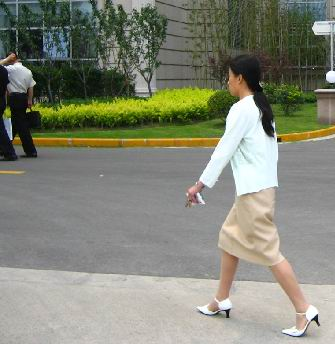

In [113]:
imgs = list(sorted(os.listdir(os.path.join(PATH, "PNGImages"))))
masks = list(sorted(os.listdir(os.path.join(PATH, "PedMasks"))))

img_path = os.path.join(PATH, "PNGImages", imgs[4])
mask_path = os.path.join(PATH, "PedMasks",masks[4])
img = Image.open(img_path).convert("RGB")
img

In [114]:
mask = Image.open(mask_path)
# convert the PIL Image into a numpy array
mask = np.array(mask)
# instances are encoded as different colors
obj_ids = np.unique(mask)
obj_ids

array([0, 1, 2], dtype=uint8)

In [115]:
# first id is the background, so remove it
obj_ids = obj_ids[1:]
obj_ids

array([1, 2], dtype=uint8)

In [116]:
# split the color-encoded mask into a set
# of binary masks
masks = mask == obj_ids[:, None, None]
masks

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [117]:
masks.shape

(2, 344, 335)

In [118]:
# get bounding box coordinates for each mask
num_objs = len(obj_ids)
num_objs

2

In [119]:
boxes = []
for i in range(num_objs):
    # return the indices of the elements that are non-zero for each dimension
    pos = np.nonzero(masks[i])
    # min value on the x-axis
    xmin = np.min(pos[1])
    # max value on the x-axis
    xmax = np.max(pos[1])
    # min value on the y-axis
    ymin = np.min(pos[0])
    # max value on the y-axis
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])

boxes

[[187, 58, 319, 335], [1, 52, 39, 157]]

In [120]:
# first mask
np.nonzero(masks[0])

(array([ 58,  58,  59, ..., 335, 335, 335]),
 array([244, 245, 239, ..., 298, 299, 300]))

In [121]:
# second mask
np.nonzero(masks[1])

(array([ 52,  52,  53, ..., 156, 157, 157]),
 array([ 9, 10,  7, ..., 36, 35, 36]))

### RESIZE BOUNDING BOX

In [36]:
transform_images = transforms.Compose(
                [
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                 ]
)

In [123]:
ds_resize = CreateDataset(PATH, transform_images, (500, 350))
ds_resize[0]

(tensor([[[ 1.4954,  1.5125,  1.5468,  ...,  0.3652,  0.3309,  0.4166],
          [ 0.9474,  0.7933,  0.8618,  ...,  0.0912,  0.0398,  0.0741],
          [ 1.3755,  1.1015,  1.1700,  ...,  0.1597,  0.1083,  0.1083],
          ...,
          [ 1.7523,  1.4954,  1.7009,  ...,  0.9988,  1.0159,  1.0502],
          [ 1.8379,  1.4783,  1.6667,  ...,  1.0502,  1.0844,  1.0673],
          [ 1.7352,  1.5639,  1.4269,  ...,  1.0844,  1.1358,  1.0844]],
 
         [[ 1.4657,  1.4832,  1.5182,  ..., -0.3200, -0.3550, -0.2675],
          [ 0.9055,  0.7479,  0.8179,  ..., -0.6001, -0.6527, -0.6176],
          [ 1.3431,  1.0630,  1.1331,  ..., -0.5301, -0.5826, -0.5826],
          ...,
          [ 1.8158,  1.5532,  1.7633,  ...,  1.1506,  1.1681,  1.2031],
          [ 1.9034,  1.5357,  1.7283,  ...,  1.2031,  1.2381,  1.2206],
          [ 1.7983,  1.6232,  1.4832,  ...,  1.2381,  1.2906,  1.2381]],
 
         [[ 1.3677,  1.3851,  1.4200,  ..., -0.4101, -0.4450, -0.3578],
          [ 0.8099,  0.6531,

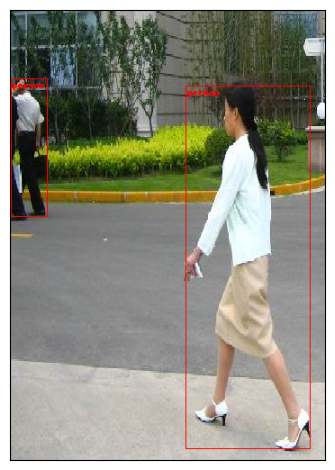

In [124]:
show_preds(ds_resize[4])

### ORIGINAL SIZE

In [125]:
ds_orig_size = CreateDataset(PATH, transform_images, None)
ds_orig_size[0]

(tensor([[[ 1.4954,  1.4783,  1.5125,  ...,  0.3309,  0.3823,  0.4166],
          [ 0.9474,  0.8447,  0.7933,  ...,  0.0398,  0.0741,  0.0741],
          [ 1.3755,  1.2043,  1.1015,  ...,  0.1083,  0.1254,  0.1083],
          ...,
          [ 1.7523,  1.5982,  1.4954,  ...,  1.0159,  1.0331,  1.0502],
          [ 1.8379,  1.6324,  1.4783,  ...,  1.0844,  1.0844,  1.0673],
          [ 1.7352,  1.7694,  1.5639,  ...,  1.1358,  1.1358,  1.0844]],
 
         [[ 1.4657,  1.4482,  1.4832,  ..., -0.3550, -0.3025, -0.2675],
          [ 0.9055,  0.8004,  0.7479,  ..., -0.6527, -0.6176, -0.6176],
          [ 1.3431,  1.1681,  1.0630,  ..., -0.5826, -0.5651, -0.5826],
          ...,
          [ 1.8158,  1.6583,  1.5532,  ...,  1.1681,  1.1856,  1.2031],
          [ 1.9034,  1.6933,  1.5357,  ...,  1.2381,  1.2381,  1.2206],
          [ 1.7983,  1.8333,  1.6232,  ...,  1.2906,  1.2906,  1.2381]],
 
         [[ 1.3677,  1.3502,  1.3851,  ..., -0.4450, -0.3927, -0.3578],
          [ 0.8099,  0.7054,

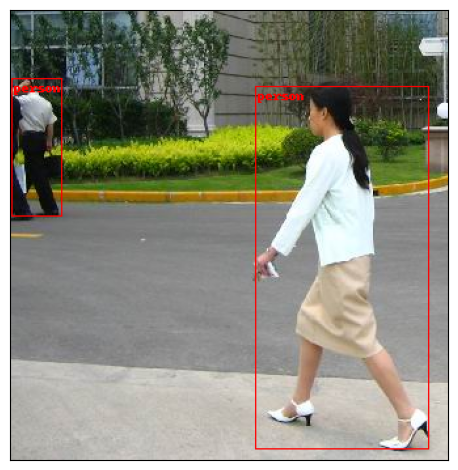

In [126]:
show_preds(ds_orig_size[4])

## ONE MORE EXAMPLE

### STEP BY STEP

In [44]:
bbox_celeba = pd.read_csv('/content/celeba/list_bbox_celeba.txt', delim_whitespace=True, header=1)
bbox_celeba.head()
# x_1 and y_1 represent the upper left point coordinate of bounding box.
bbox_celeba.head()

image_id  x_1  y_1  width  height
0  000001.jpg   95   71    226     313
1  000002.jpg   72   94    221     306
2  000003.jpg  216   59     91     126
3  000004.jpg  622  257    564     781
4  000005.jpg  236  109    120     166

In [45]:
box = bbox_celeba.iloc[0][1:].values
x_1 = box[0]
y_1 = box[1]
x_2 = x_1 + box[2]
y_2 =  y_1 + box[3]
bbox = [x_1, y_1, x_2, y_2]
bbox

[95, 71, 321, 384]

In [46]:
PATH = Path('/content/celeba/images/')

In [130]:
trans_to_tensor = transforms.ToTensor()

In [131]:
img = ImageFolder(PATH)

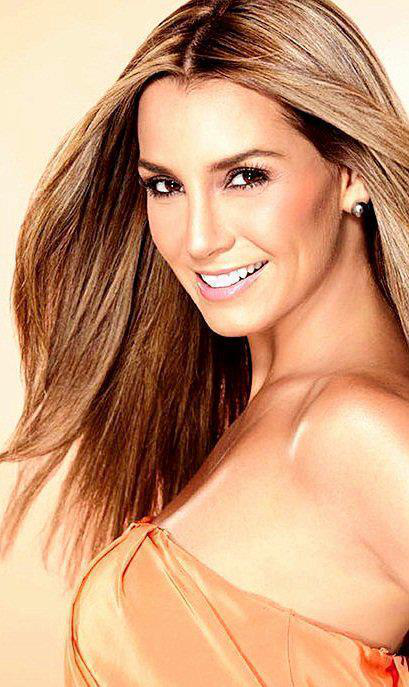

In [132]:
img[0][0]

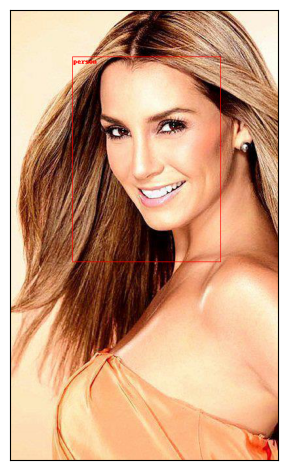

In [133]:
show_preds(transform_images(img[0][0]), torch.Tensor(bbox).unsqueeze(0))

In [134]:
torch_bbox = datapoints.BoundingBox(
    bbox,
    format=datapoints.BoundingBoxFormat.XYXY,
    spatial_size=transform_images(img[0][0]).shape[-2:]
    )

In [135]:
transform_images(img[0][0]).shape[-2:]

torch.Size([687, 409])

In [136]:
img = Image.open('/content/celeba/split/train/0_30k/000001.jpg').convert("RGB")
img.size

(409, 687)

In [137]:
img.size[::-1]

(687, 409)

In [138]:
resize = transforms.v2.Resize((500, 300))

In [139]:
resize(torch_bbox)

BoundingBox([ 69,  51, 235, 279], format=BoundingBoxFormat.XYXY, spatial_size=(500, 300))

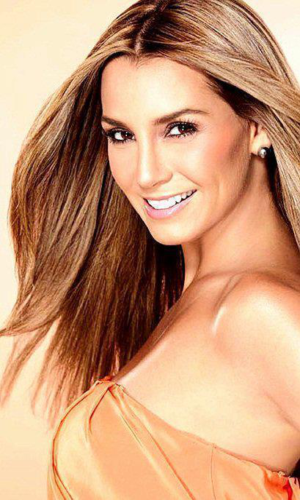

In [141]:
resize(img)

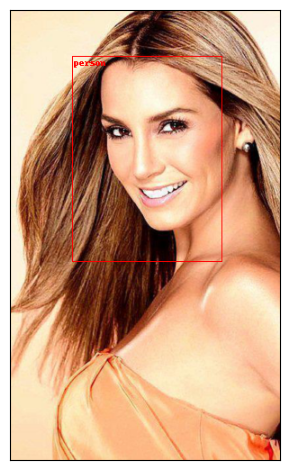

In [144]:
show_preds(transform_images(resize(img)), resize(torch_bbox).unsqueeze(0))

### MASS FUNCTION

In [47]:
bbox_celeba['x_2'] =  bbox_celeba['x_1'] + bbox_celeba['width']
bbox_celeba['y_2'] =  bbox_celeba['y_1'] + bbox_celeba['height']
bbox_celeba = bbox_celeba.drop(['width', 'height'], axis=1)
all_bboxes = bbox_celeba.to_numpy()
all_bboxes

array([['000001.jpg', 95, 71, 321, 384],
       ['000002.jpg', 72, 94, 293, 400],
       ['000003.jpg', 216, 59, 307, 185],
       ...,
       ['202597.jpg', 53, 76, 144, 202],
       ['202598.jpg', 195, 28, 286, 154],
       ['202599.jpg', 101, 101, 280, 349]], dtype=object)

In [48]:
image_names = sorted(os.listdir(TRAIN_PATH / Path("0_30k")))
image_names[:3]

['000001.jpg', '000002.jpg', '000003.jpg']

In [56]:
val_image_names = sorted(os.listdir(VAL_PATH / Path("0_30k")))
val_image_names[:3]

['000006.jpg', '000023.jpg', '000036.jpg']

In [50]:
all_bboxes[:, 0]

array(['000001.jpg', '000002.jpg', '000003.jpg', ..., '202597.jpg',
       '202598.jpg', '202599.jpg'], dtype=object)

In [51]:
all_bboxes[:, 1:]

array([[95, 71, 321, 384],
       [72, 94, 293, 400],
       [216, 59, 307, 185],
       ...,
       [53, 76, 144, 202],
       [195, 28, 286, 154],
       [101, 101, 280, 349]], dtype=object)

In [52]:
train_bboxes = []
for i in image_names:
  train_bboxes.append(all_bboxes[:, 1:][np.where(all_bboxes[:, 0] == i)].reshape(-1).tolist())
train_bboxes[:3]

[[95, 71, 321, 384], [72, 94, 293, 400], [216, 59, 307, 185]]

In [57]:
val_bboxes = []
for i in val_image_names:
  val_bboxes.append(all_bboxes[:, 1:][np.where(all_bboxes[:, 0] == i)].reshape(-1).tolist())
val_bboxes[:3]

[[146, 67, 328, 319], [159, 94, 390, 414], [102, 56, 227, 229]]

In [58]:
class CreateDatasetBoxes(torch.utils.data.Dataset):
    def __init__(self, root, transform, bboxes, resize_size=None):
        self.root = root
        self.transforms = transform
        self.bboxes = bboxes
        self.imgs = list(sorted(os.listdir(os.path.join(root, "0_30k"))))
        if resize_size is not None:
          self.resize = transforms.v2.Resize(resize_size)
        else:
          self.resize = None


    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "0_30k", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        # too slow for each try
        '''
        mask = np.isin(element=self.bboxes[:, 0], test_elements=self.image_names)
        selected_bboxes = self.bboxes[mask, 1:].astype(dtype=float)


        selected_bboxes = []
        for i in self.image_names:
          selected_bboxes.append(self.bboxes[:, 1:][np.where(self.bboxes[:, 0] == i)].reshape(-1).tolist())

        selected_bboxes = np.asarray(selected_bboxes).astype(dtype=float)
        '''


        torch_bbox = datapoints.BoundingBox(
            self.bboxes[idx],
            format=datapoints.BoundingBoxFormat.XYXY,
            spatial_size=img.size[::-1]
            )

        if self.resize is not None:
          img = self.resize(img)
          bboxes = self.resize(torch_bbox)

        labels = torch.ones((1), dtype=torch.int64)
        bboxes = torch.as_tensor(bboxes, dtype=torch.int64)
        bboxes = bboxes.unsqueeze(0)
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((1), dtype=torch.int64)

        target = {}
        target["boxes"] = bboxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd


        if self.transforms is not None:
          img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [59]:
transform_images = transforms.Compose(
                [
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                 ]
)

In [60]:
ds_celeba_train = CreateDatasetBoxes(TRAIN_PATH, transform_images, train_bboxes, (500, 300))
ds_celeba_train[3]

(tensor([[[-2.0323, -2.0152, -2.0152,  ..., -2.0837, -2.0665, -2.0665],
          [-2.0323, -2.0152, -2.0152,  ..., -2.0837, -2.0665, -2.0665],
          [-2.0323, -1.9980, -2.0152,  ..., -2.0837, -2.0837, -2.0494],
          ...,
          [-2.0837, -2.0837, -2.0837,  ..., -1.7240, -1.6898, -1.6384],
          [-2.0837, -2.0837, -2.0837,  ..., -1.6384, -1.6555, -1.6898],
          [-2.0837, -2.0837, -2.0837,  ..., -1.5699, -1.6555, -1.6727]],
 
         [[-1.9307, -1.9132, -1.9132,  ..., -2.0007, -1.9832, -1.9832],
          [-1.9307, -1.9132, -1.9132,  ..., -2.0007, -1.9832, -1.9832],
          [-1.9307, -1.8957, -1.9132,  ..., -2.0007, -2.0007, -1.9657],
          ...,
          [-2.0007, -2.0007, -2.0007,  ..., -1.5980, -1.6155, -1.6155],
          [-2.0007, -2.0007, -2.0007,  ..., -1.5980, -1.5805, -1.5980],
          [-2.0007, -2.0007, -2.0007,  ..., -1.5980, -1.5805, -1.5455]],
 
         [[-1.7696, -1.7522, -1.7696,  ..., -1.7696, -1.7522, -1.7522],
          [-1.7696, -1.7696,

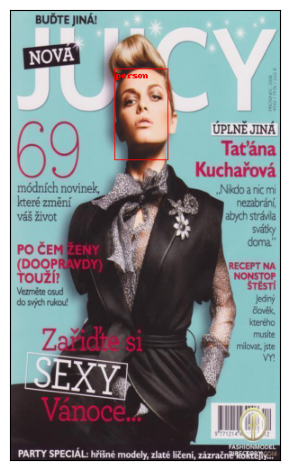

In [157]:
show_preds(ds_celeba_train[4])

In [61]:
ds_celeba_val = CreateDatasetBoxes(VAL_PATH, transform_images, val_bboxes, (500, 350))
ds_celeba_val[0]

(tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  1.7523,  1.7523,  1.7523],
          [ 2.2489,  2.2489,  2.2489,  ...,  1.7523,  1.7523,  1.7523],
          [ 2.2489,  2.2489,  2.2489,  ...,  1.7523,  1.7523,  1.7523],
          ...,
          [ 0.7419,  0.7591,  0.8276,  ...,  0.5536,  0.5536,  0.5536],
          [ 0.7077,  0.7933,  0.8447,  ...,  0.5364,  0.5364,  0.5364],
          [ 0.6906,  0.8104,  0.8618,  ...,  0.5364,  0.5364,  0.5364]],
 
         [[ 2.4286,  2.4286,  2.4286,  ...,  1.9209,  1.9209,  1.9209],
          [ 2.4286,  2.4286,  2.4286,  ...,  1.9209,  1.9209,  1.9209],
          [ 2.4286,  2.4286,  2.4286,  ...,  1.9209,  1.9209,  1.9209],
          ...,
          [-0.2500, -0.2150, -0.1275,  ...,  0.6954,  0.6954,  0.6954],
          [-0.2850, -0.1800, -0.1099,  ...,  0.6779,  0.6779,  0.6779],
          [-0.3025, -0.1625, -0.0924,  ...,  0.6779,  0.6779,  0.6779]],
 
         [[ 2.6400,  2.6400,  2.6400,  ...,  2.1346,  2.1346,  2.1346],
          [ 2.6400,  2.6400,

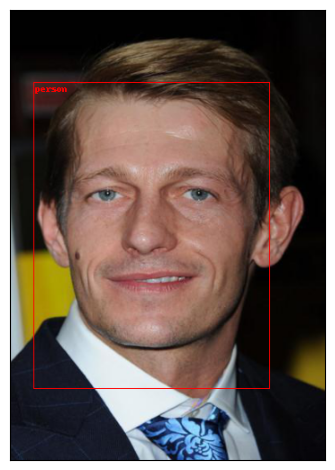

In [159]:
show_preds(ds_celeba_val[13])

### PART II

<a href='https://colab.research.google.com/drive/1-bfT_ZtKhW88I-MNtmCFy3y1a1jWv4Pp#scrollTo=DFx8--zq4inG'>link</a>